In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
np.random.seed(365)
from numpy import mean
import pickle
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 
from statsmodels.tsa.statespace.sarimax import SARIMAX 



### Read in Datasets for all boroughs

In [11]:
all_df = pickle.load(open('./data/final_cleaned_data/all_cleaned_data.pkl','rb'))
bronx_df = pickle.load(open('./data/final_cleaned_data/bronx_cleaned_data.pkl','rb'))
brooklyn_df = pickle.load(open('./data/final_cleaned_data/brooklyn_cleaned_data.pkl','rb'))
manhattan_df = pickle.load(open('./data/final_cleaned_data/manhattan_cleaned_data.pkl','rb'))
queens_df = pickle.load(open('./data/final_cleaned_data/queens_cleaned_data.pkl','rb'))
staten_df = pickle.load(open('./data/final_cleaned_data/staten_cleaned_data.pkl','rb'))

##### we will use 2020-03-22 which was the start of lockdown in NYC

In [12]:
# Manhattan 
#man_precovid_df = manhattan_df[:'2020-03-21']
man_covid_df = manhattan_df['2020-03-22':]

#Queens
#queens_precovid_df = queens_df[:'2020-03-21']
queens_covid_df = queens_df['2020-03-22':]

# Brooklyn
#brooklyn_precovid_df = brooklyn_df[:'2020-03-21']
brooklyn_covid_df = brooklyn_df['2020-03-22':]

# Bronx
#bronx_precovid_df = bronx_df[:'2020-03-21']
bronx_covid_df = bronx_df['2020-03-22':]

# Staten Island
#staten_precovid_df = staten_df[:'2020-03-21']
staten_covid_df = staten_df['2020-03-22':]

## Train Test Split our data. We will use 2020-03-22 to 2020-05-31 as our Train set and month of June for our test set (it's sequential)

In [13]:
## PRECOVID TRAIN(70%), TEST SET(30%)
#X = man_precovid_df.values
#size = int(len(X) * 0.70)
#man_precovid_train, man_precovid_test  = man_precovid_df[:'2020-02-29'], man_precovid_df['2020-02-29':]
#queens_precovid_train, queens_precovid_test  = queens_precovid_df[:size], queens_precovid_df[size:]
#brooklyn_precovid_train, brooklyn_precovid_test  = brooklyn_precovid_df[:size], brooklyn_precovid_df[size:]
#bronx_precovid_train, bronx_precovid_test  = bronx_precovid_df[:size], bronx_precovid_df[size:]
#staten_precovid_train, staten_precovid_test  = staten_precovid_df[:size], staten_precovid_df[size:]

covid='2020-05-31'
lockdown='2020-03-22'
man_covid_train, man_covid_test = man_covid_df[lockdown:covid], man_covid_df['2020-06-01':]
queens_covid_train, queens_covid_test = queens_covid_df[lockdown:covid], queens_covid_df['2020-06-01':]
brooklyn_covid_train, brooklyn_covid_test = brooklyn_covid_df[lockdown:covid], brooklyn_covid_df['2020-06-01':]
bronx_covid_train, bronx_covid_test = bronx_covid_df[lockdown:covid], bronx_covid_df['2020-06-01':]
staten_covid_train, staten_covid_test = staten_covid_df[lockdown:covid], staten_covid_df['2020-06-01':]

In [14]:
queens_covid_train

,count
pickup_time,
2020-03-22 00:00:00,34
2020-03-22 01:00:00,46
2020-03-22 02:00:00,23
2020-03-22 03:00:00,4
2020-03-22 04:00:00,11
...,...
2020-05-31 19:00:00,27
2020-05-31 20:00:00,40
2020-05-31 21:00:00,15


### placeholder for the RMSE scores: I will bring the results from 03.Baseline_Models_postcovid.ipynb

In [15]:
placeholder_man = pickle.load(open('./data/pickled/placeholder_manhattan_covid.pkl','rb'))
placeholder_queens = pickle.load(open('./data/pickled/placeholder_queens_covid.pkl','rb'))
placeholder_brooklyn = pickle.load(open('./data/pickled/placeholder_brooklyn_covid.pkl','rb'))
placeholder_bronx = pickle.load(open('./data/pickled/placeholder_bronx_covid.pkl','rb'))
placeholder_staten = pickle.load(open('./data/pickled/placeholder_staten_covid.pkl','rb'))
placeholder_man

{'naive_forecast_baseline': 649.1469776646204,
 'moving_average_baseline': 264.77391785368604,
 'rmse_holt_linear': 101.45008150531622,
 'rmse_holt_winter': 45.0425549718788}

# Manhattan

## PRE-COVID:

### Dickey-Fuller Test to check if our data is stationay for Manhattan:

In [16]:
## CHECK TO SEE IF OUR DATA IS STATINONARY
ad_test = adfuller(man_covid_train['count'])
print('ADF Statistic: %f' % ad_test[0])
print('p-value: %f' % ad_test[1])
print('Critical Values:')
for key, value in ad_test[4].items():
    print('\t%s: %.3f' % (key, value))
print('number of observations used:', ad_test[3])
print('lags used:', ad_test[2])

ADF Statistic: -5.235468
p-value: 0.000007
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
number of observations used: 1678
lags used: 25


We can see here that our p-value is less than our alpha value and also test statistic is less than the critical value, so we can reject the null hypothesis. (null hypothesis is the data is not stationary). So our data is stationary. We do not need to difference our data.

## ACF AND PACF

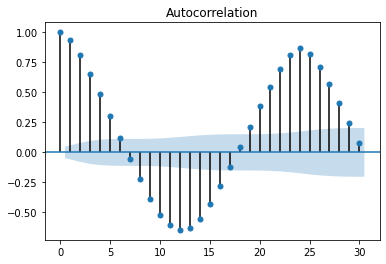

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(man_covid_train['count'], alpha=.05, lags=30);

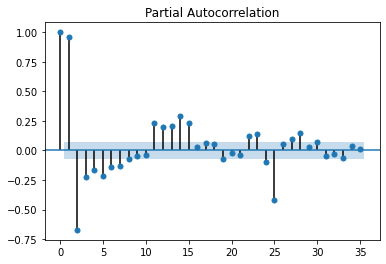

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(man_covid_test['count'], alpha=.05, lags=35);

#### ARIMA #1:

In [19]:
model = ARIMA(man_covid_train, order=(3,0,2)) 
arima_1 = model.fit(disp=0)
print(arima_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                 1704
Model:                     ARMA(3, 2)   Log Likelihood               -9561.518
Method:                       css-mle   S.D. of innovations             66.113
Date:                Thu, 12 Nov 2020   AIC                          19137.036
Time:                        07:58:54   BIC                          19175.122
Sample:                    03-22-2020   HQIC                         19151.134
                         - 05-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         350.6522      8.124     43.164      0.000     334.730     366.574
ar.L1.count     1.9564      0.090     21.813      0.000       1.781       2.132
ar.L2.count    -1.1184      0.165     -6.776    

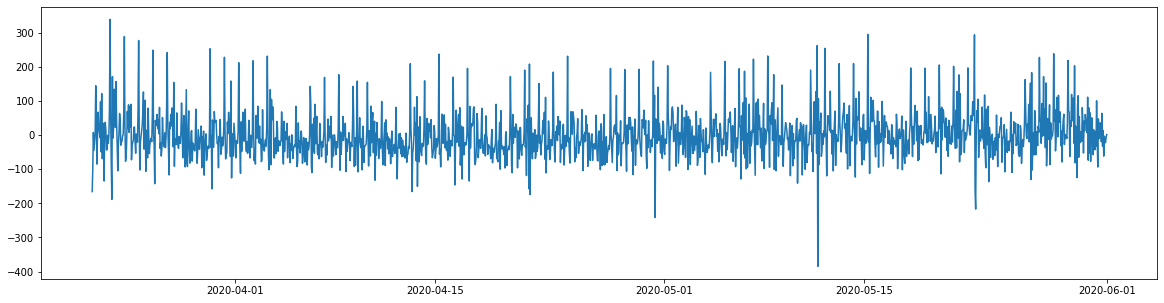

,0
count,1704.000000
mean,-0.097791
std,66.261114
min,-384.949995
25%,-37.403833
50%,-6.537766
75%,30.537029
max,339.086035


In [20]:
plt.figure(figsize=(20,5))  # plot the residuals

residuals = pd.DataFrame(arima_1.resid)
plt.plot(residuals)
plt.show()
residuals.describe()

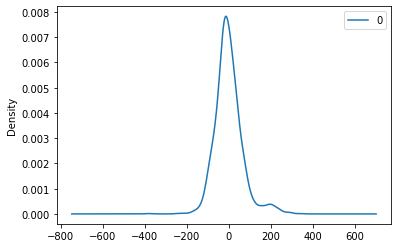

In [21]:
residuals = pd.DataFrame(arima_1.resid)  # plot the residuals distribution
residuals.plot(kind='kde',)
plt.show()

In [22]:
# evaluate the model on the training data
train_arma_rmse = np.sqrt(np.mean(arima_1.resid**2))  # check the RMSE scores
placeholder_man['arima_1'] = train_arma_rmse

placeholder_man

{'naive_forecast_baseline': 649.1469776646204,
 'moving_average_baseline': 264.77391785368604,
 'rmse_holt_linear': 101.45008150531622,
 'rmse_holt_winter': 45.0425549718788,
 'arima_1': 66.24174011651407}

Seems like our arima model did not do as well as our holt winter model but definitely did alot better than baseline models. Let's see if we can improve this by adding some more complexity.

In [23]:
# get predictions for the test data
predictions = arima_1.predict(start=man_covid_test.index[0], end=man_covid_test.index[-1])
residuals = man_covid_test['count'] - predictions  # get the residuals
test_arma_rmse = np.sqrt(np.mean(residuals**2))
print(test_arma_rmse)

575.0377537942445


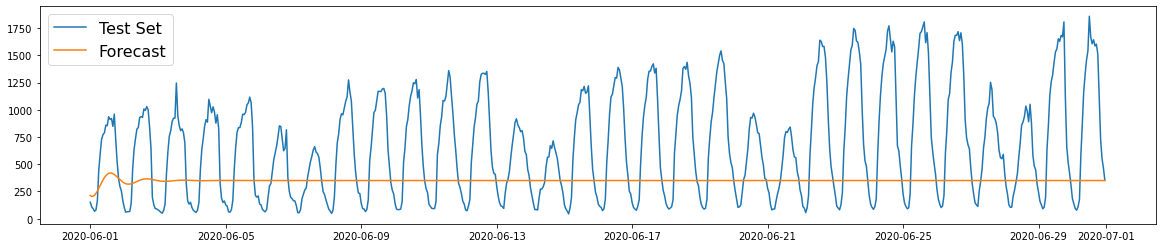

In [24]:
plt.figure(figsize=(20,4))  # plot the predictions and the actual data

plt.plot(man_covid_test)
plt.plot(predictions)

plt.legend(('Test Set', 'Forecast'), fontsize=16)

Seems we are forecasting at a constant level. We will see if we can improve this with another model to see if we can cast better predictions.

## ARIMA 2

Now, pmdarima is a library that has auto_arima() method that helps search for the best params. I will use this method to see if I can try to find best params and use that param to get better predictions. We will do this in step-wise 

In [25]:
model_2 = SARIMAX(man_covid_df['count'], order = (3, 0, 2)) 
  
result = model_2.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  count   No. Observations:                 2424
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -14183.131
Date:                Thu, 12 Nov 2020   AIC                          28378.262
Time:                        07:59:03   BIC                          28413.021
Sample:                    03-22-2020   HQIC                         28390.901
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7879      7.033      0.112      0.911     -12.996      14.571
ar.L2          0.8132     11.909      0.068      0.946     -22.528      24.154
ar.L3         -0.6475      5.048     -0.128      0.898     -10.540       9.245
ma.L1          0.6954      7.034      0.099      0.921     -13.091      14.482
ma.L2         -0.1883      1.484     -0.127      0.899      -3.096       2.720
sigma2      7078.7408    109.069     64.902      0.000    6864.970    7292.512
===================================================================================
Ljung-Box (Q):                     1660.57   Jarque-Bera (JB):              4649.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'Forecasting from March 22nd to June 30th (After Covid Lockdown)')

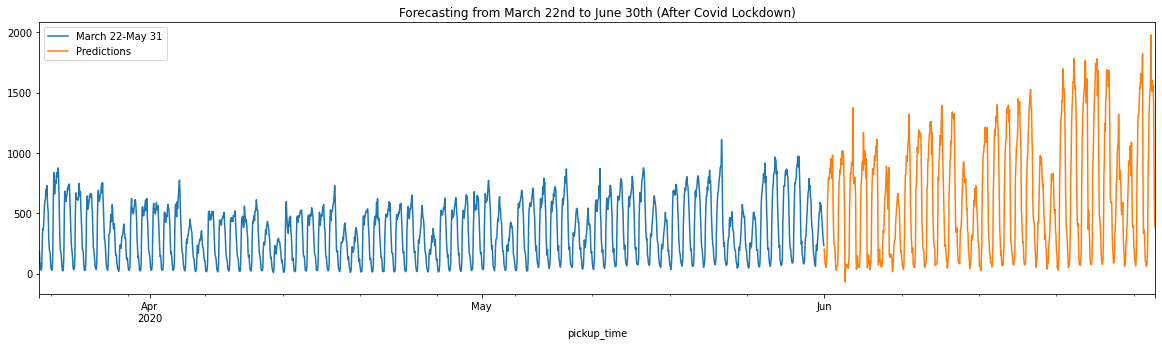

In [26]:
start = len(man_covid_train) 
end = len(man_covid_train) + len(man_covid_test) - 1
  
# Predictions for one-month against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
fig, ax = plt.subplots(figsize=(20, 5))
man_covid_train.plot(legend=True, ax=ax)
predictions.plot(legend = True, ax=ax) 
#man_covid_test['count'].plot(legend = True, ax=ax)
plt.legend(['March 22-May 31', 'Predictions'])
plt.title('Forecasting from March 22nd to June 30th (After Covid Lockdown)')

Text(0.5, 1.0, 'Forecasting from December 24th to March 21st (before Covid Lockdown)')

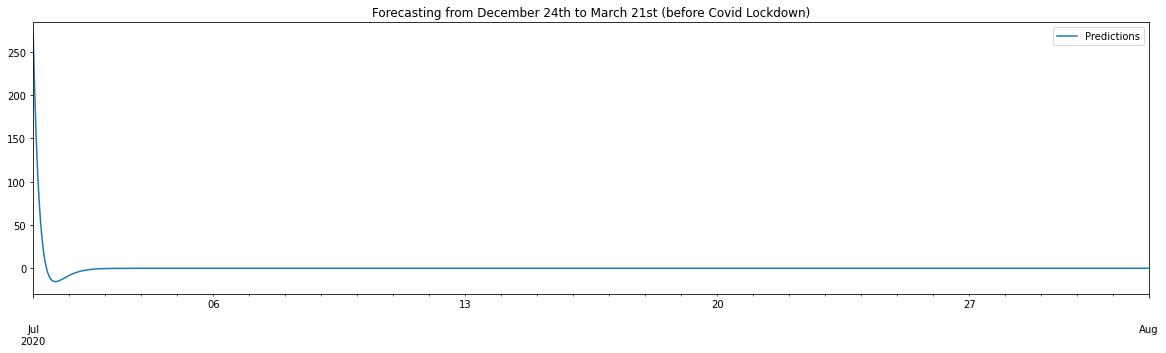

In [27]:
#start = len(man_covid_train) 
#end = len(man_covid_train) + len(man_covid_test) - 1
  
# Predictions for one-month against the test set 
june_predictions = result.predict('2020-07-01', '2020-08-01', 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
fig, ax = plt.subplots(figsize=(20, 5))
june_predictions.plot(legend = True) 
#man_covid_test['count'].plot(legend = True) 
plt.title('Forecasting from December 24th to March 21st (before Covid Lockdown)')

In [28]:
# Calculate root mean squared error 
print('RMSE for ARIMA#2:' ,rmse(man_covid_test["count"], predictions))

placeholder_man['arima_2'] = rmse(man_covid_test["count"], predictions) 

RMSE for ARIMA#2: 108.2976291469606


### Forecasting using ARIMA model that we made for unknown data of July

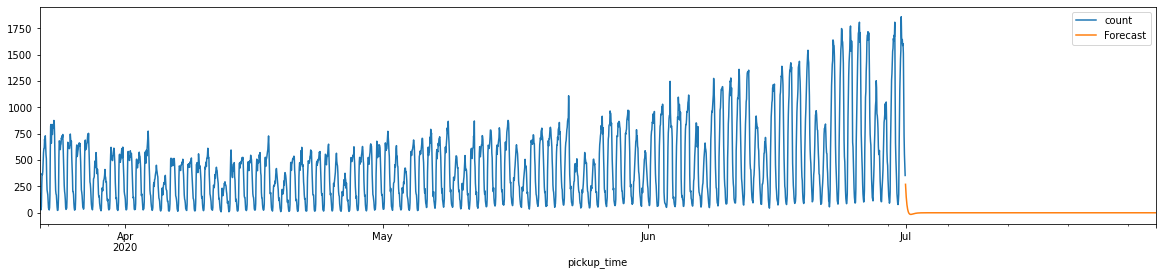

In [29]:
# Train the model on the full dataset 
model = SARIMAX(man_covid_df['count'],  order = (2, 0, 1)) 
result = model.fit() 
  
# Forecast for the next 3 years 
forecast = result.predict(start = len(man_covid_df),  
                          end = (len(man_covid_df)) + 700,  
                          typ='levels').rename('Forecast') 
  
# Plot the forecast values 
man_covid_df['count'].plot(figsize = (20, 4), legend = True) 
forecast.plot(legend = True) 

Even though our RMSE score was decently low, there was definitely something wrong when we tried to forecast July. Something really does not seem right as my forecast for the next month was predicting that there would be 0 number of pickups. Let's see if we can add seasonal component to try to resolve this issue.

## SARIMA

Since our ARIMA model was not forecasting well, let's see how our model does with seasonal order. I put seasonality of 24 because my dataset is by hour interval

Instantiate a SARIMAX model without exogenous variable then fit the model and view the summary

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (2,0,1)
seasonal_order = (2, 0, 1, 24)

model = SARIMAX(man_covid_train['count'], seasonal_order=seasonal_order, order=order, freq='H')
sarima_1 = model.fit()


In [32]:
sarima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                 1704
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 24)   Log Likelihood               -8806.642
Date:                            Thu, 12 Nov 2020   AIC                          17627.283
Time:                                    08:04:49   BIC                          17665.368
Sample:                                03-22-2020   HQIC                         17641.381
                                     - 05-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7256      0.070     24.528      0.000       1.588       1.863
ar.L2         -0.7490      0.065    -11.582      0.000      -0.876      -0.622
ma.L1         -0.7519      0.072    -10.465      0.000      -0.893      -0.611
ar.S.L24       1.1374      0.018     62.070      0.000       1.101       1.173
ar.S.L48      -0.1382      0.018     -7.615      0.000      -0.174      -0.103
ma.S.L24      -0.9366      0.011    -83.212      0.000      -0.959      -0.915
sigma2      1726.6357     34.276     50.374      0.000    1659.456    1793.816
===================================================================================
Ljung-Box (Q):                      142.99   Jarque-Bera (JB):              1732.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
man_covid_test

,count
pickup_time,
2020-06-01 00:00:00,151
2020-06-01 01:00:00,109
2020-06-01 02:00:00,92
2020-06-01 03:00:00,68
2020-06-01 04:00:00,80
...,...
2020-06-30 19:00:00,1130
2020-06-30 20:00:00,730
2020-06-30 21:00:00,553


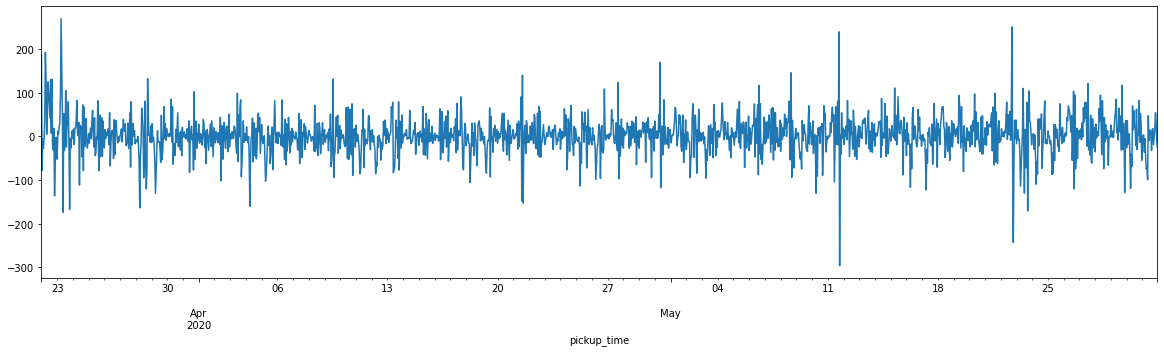

In [34]:
fig, ax = plt.subplots(figsize=(20, 5))
sarima_1.resid.plot()

In [35]:
sarima_1.resid.describe()

count    1704.000000
mean        1.575600
std        43.347328
min      -296.451546
25%       -18.308027
50%         1.077454
75%        22.880045
max       270.105929
dtype: float64

Because the mean of the residual is a non-zero value, we can note that there may be bias in the prediction. 

In [36]:
predictions = sarima_1.predict(start='2020-06-01', end='2020-07-01')
predictions

2020-06-01 00:00:00    151.756636
2020-06-01 01:00:00    112.150757
2020-06-01 02:00:00     91.348595
2020-06-01 03:00:00     71.328150
2020-06-01 04:00:00     79.851633
                          ...    
2020-06-30 20:00:00    347.835412
2020-06-30 21:00:00    244.415761
2020-06-30 22:00:00    203.869290
2020-06-30 23:00:00    203.840309
2020-07-01 00:00:00    128.308448
Freq: H, Length: 721, dtype: float64

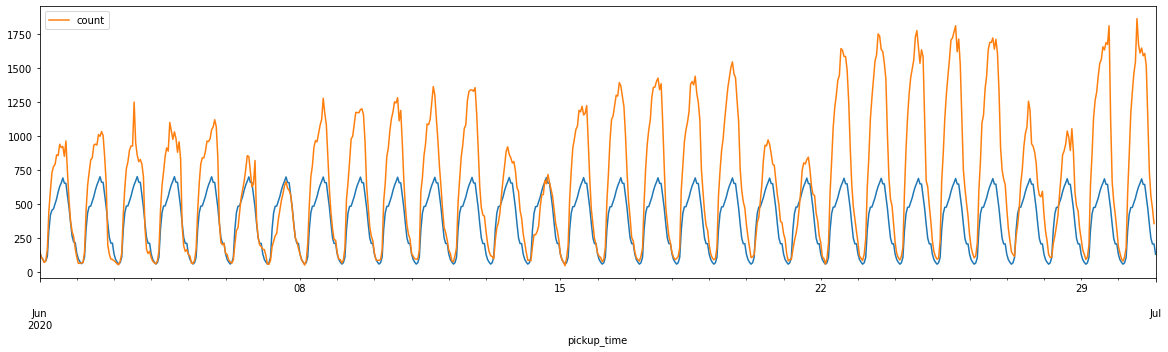

In [37]:
fig, ax = plt.subplots(figsize=(20, 5))
predictions.plot(ax=ax)
man_covid_test.plot(ax=ax)

In [38]:
# evaluate the model on the training data
train_sarima_rmse = np.sqrt(np.mean(sarima_1.resid**2))  # check the RMSE scores
placeholder_man['sarima_1'] = train_sarima_rmse

placeholder_man

{'naive_forecast_baseline': 649.1469776646204,
 'moving_average_baseline': 264.77391785368604,
 'rmse_holt_linear': 101.45008150531622,
 'rmse_holt_winter': 45.0425549718788,
 'arima_1': 66.24174011651407,
 'arima_2': 108.2976291469606,
 'sarima_1': 43.36324070854471}

The predictions are not as accuracte since it just seems like its repeating on each day and having the same loop. However this does alot better than our earlier models. And RMSE is at its lowest. I will try to make it more complex by adding exogenous variables. 

#### SARMIAX

##### Adding Exogenous Variable: Date Extraction by Hour, dayofweek and month:

First exogenous variable: hour

In [39]:
# Copy the train set and index by hour
copied_train = man_covid_train.copy()
hour = pd.DataFrame(copied_train.index.hour)
hour

,pickup_time
0,0
1,1
2,2
3,3
4,4
...,...
1699,19
1700,20
1701,21
1702,22


##### Assign hour column to train set to specify which hour the observation is at:

In [40]:

copied_train['hour'] = copied_train.index.hour
copied_train

,count,hour
pickup_time,,
2020-03-22 00:00:00,185,0
2020-03-22 01:00:00,94,1
2020-03-22 02:00:00,77,2
2020-03-22 03:00:00,40,3
2020-03-22 04:00:00,28,4
...,...,...
2020-05-31 19:00:00,435,19
2020-05-31 20:00:00,375,20
2020-05-31 21:00:00,309,21


Second Exogenous Variable: assign day of week (5 and 6 are Saturday and Sunday)

In [41]:
copied_train.index.dayofweek

Int64Index([6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
            ...
            6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
           dtype='int64', name='pickup_time', length=1704)

In [42]:
# assign week day and weekend
copied_train['day'] = copied_train.index.dayofweek
copied_train

,count,hour,day
pickup_time,,,
2020-03-22 00:00:00,185,0,6
2020-03-22 01:00:00,94,1,6
2020-03-22 02:00:00,77,2,6
2020-03-22 03:00:00,40,3,6
2020-03-22 04:00:00,28,4,6
...,...,...,...
2020-05-31 19:00:00,435,19,6
2020-05-31 20:00:00,375,20,6
2020-05-31 21:00:00,309,21,6


##### Now we want to dummy the data by using OneHotEncoder

In [43]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first')
ohe_fit = ohe.fit_transform(copied_train[['hour', 'day']]).toarray() ## fit transform hour and day

In [44]:
exog_df = pd.DataFrame(data=ohe_fit, index=copied_train.index, columns=ohe.get_feature_names(['hour', 'day']))
exog_df

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,...,hour_20,hour_21,hour_22,hour_23,day_1,day_2,day_3,day_4,day_5,day_6
pickup_time,,,,,,,,,,,,,,,,,,,,,
2020-03-22 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-03-22 01:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-03-22 02:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-03-22 03:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-03-22 04:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-05-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-05-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Create SARIMAX Model:

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (2,0,2)
seasonal_order = (2, 0, 2, 24)

model = SARIMAX(copied_train['count'], exog= exog_df, seasonal_order=seasonal_order, order=order, freq='H')
sarimax_1 = model.fit()


In [46]:
sarimax_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                 1704
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood               -8810.333
Date:                            Thu, 12 Nov 2020   AIC                          17696.666
Time:                                    08:20:38   BIC                          17903.414
Sample:                                03-22-2020   HQIC                         17773.196
                                     - 05-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour_1        43.6400     20.161      2.165      0.030       4.125      83.155
hour_2        26.2169     61.851      0.424      0.672     -95.008     147.442
hour_3        17.9693    107.609      0.167      0.867    -192.941     228.880
hour_4        25.9084    129.686      0.200      0.842    -228.272     280.089
hour_5        77.8548    123.382      0.631      0.528    -163.970     319.679
hour_6       306.4831    113.985      2.689      0.007      83.077     529.889
hour_7       432.1493    100.283      4.309      0.000     235.599     628.700
hour_8       464.0923     85.769      5.411      0.000     295.987     632.197
hour_9       437.1307     70.992      6.157      0.000     297.989     576.272
hour_10      459.0109     59.528      7.711      0.000     342.338     575.684
hour_11      484.1987     53.574      9.038      0.000     379.195     589.202
hour_12      512.3479     51.425      9.963      0.000     411.556     613.140
hour_13      544.5600     47.968     11.353      0.000     450.544     638.576
hour_14      578.2608     46.220     12.511      0.000     487.671     668.850
hour_15      602.6001     46.681     12.909      0.000     511.107     694.093
hour_16      575.9196     42.948     13.410      0.000     491.743     660.096
hour_17      572.2713     41.637     13.744      0.000     490.664     653.878
hour_18      487.7549     41.297     11.811      0.000     406.814     568.696
hour_19      405.9198     38.763     10.472      0.000     329.945     481.895
hour_20      295.9783     40.273      7.349      0.000     217.045     374.912
hour_21      192.5420     45.924      4.193      0.000     102.532     282.552
hour_22      156.9444     43.728      3.589      0.000      71.239     242.649
hour_23      156.9108     28.947      5.421      0.000     100.176     213.646
day_1         48.2294     15.784      3.056      0.002      17.294      79.165
day_2         60.2272     18.103      3.327      0.001      24.747      95.708
day_3         61.4274     17.837      3.444      0.001      26.468      96.387
day_4         95.1368     14.825      6.417      0.000      66.079     124.194
day_5        -35.0682     12.761     -2.748      0.006     -60.079     -10.057
day_6        -83.3920      9.333     -8.935      0.000    -101.685     -65.099
ar.L1          1.3610      0.140      9.687      0.000       1.086       1.636
ar.L2         -0.4689      0.120     -3.914      0.000      -0.704      -0.234
ma.L1         -0.4961      0.140     -3.547      0.000      -0.770      -0.222
ma.L2          0.1490      0.025      5.949      0.000       0.100       0.198
ar.S.L24       0.9115      0.183      4.974      0.000       0.552       1.271
ar.S.L48       0.0729      0.179      0.408      0.684      -0.278       0.423
ma.S.L24      -0.6917      0.184     -3.753      0.000      -1.053      -0.330
ma.S.L48      -0.2034      0.160     -1.273      0.2

We can see that the exog variables are very significant from looking at coefficients. This means that our exogenous variables are good determinants for our model. 

Now we want to see if we can use our model to accurately predict with our test set. We need to recreate our exog variables to match the same number of index of our test set. 

In [47]:
exog2_df = pd.DataFrame(index=pd.date_range(start="2020-06-01", end="2020-07-01", freq='H'))
exog2_df['hour'] = exog2_df.index.hour
exog2_df['day'] = exog2_df.index.dayofweek ## create day 
exog2_df

,hour,day
2020-06-01 00:00:00,0,0
2020-06-01 01:00:00,1,0
2020-06-01 02:00:00,2,0
2020-06-01 03:00:00,3,0
2020-06-01 04:00:00,4,0
...,...,...
2020-06-30 20:00:00,20,1
2020-06-30 21:00:00,21,1
2020-06-30 22:00:00,22,1
2020-06-30 23:00:00,23,1


In [48]:
ohe_2 = ohe.transform(exog2_df[['hour', 'day']]).toarray()
ohe_2

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
predictions_june = sarimax_1.predict(start='2020-06-01', end='2020-07-01', exog=ohe_2)
predictions_june

2020-06-01 00:00:00    213.053731
2020-06-01 01:00:00    166.647350
2020-06-01 02:00:00    129.952952
2020-06-01 03:00:00     96.002406
2020-06-01 04:00:00     94.214537
                          ...    
2020-06-30 20:00:00    379.457538
2020-06-30 21:00:00    272.596030
2020-06-30 22:00:00    232.510877
2020-06-30 23:00:00    231.591708
2020-07-01 00:00:00    131.145362
Freq: H, Length: 721, dtype: float64

Text(0.5, 1.0, 'SARIMAX: Manhattan after Lockdown')

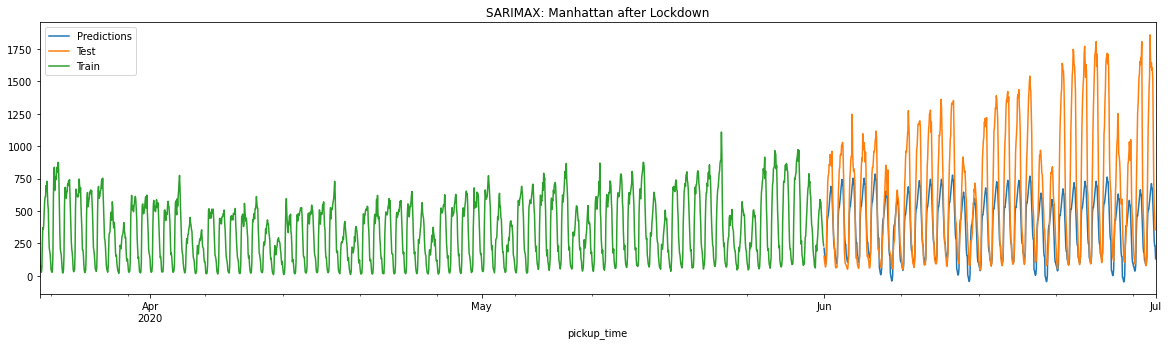

In [50]:
fig, ax = plt.subplots(figsize=(20, 5))
predictions_june.plot(ax=ax)
man_covid_test.plot(ax=ax)
man_covid_train.plot(ax=ax)
plt.legend(['Predictions', 'Test', 'Train'])
plt.title('SARIMAX: Manhattan after Lockdown')

In [51]:
# evaluate the model on the training data
train_sarimax_rmse = np.sqrt(np.mean(sarimax_1.resid**2))  # check the RMSE scores
placeholder_man['sarimax_1'] = train_sarimax_rmse

placeholder_man

{'naive_forecast_baseline': 649.1469776646204,
 'moving_average_baseline': 264.77391785368604,
 'rmse_holt_linear': 101.45008150531622,
 'rmse_holt_winter': 45.0425549718788,
 'arima_1': 66.24174011651407,
 'arima_2': 108.2976291469606,
 'sarima_1': 43.36324070854471,
 'sarimax_1': 43.01682788966126}

Our SARIMAX model with two exogenous variables had the lowest RMSE score. On June 8th, Phase One had started and you can see how the demand for yellow cabs started to increase and continue to increase. Phase two started on June 22nd. So the trend seems to be increaasing as the lockdown started to loosen up. The only downside of this model is that the start of the ease on NYC lockdown was not considered. So you can see my predictions just continue off from the way my trainset was reflected upon and missing the abnormality. 

# FACEBOOK PROPHET

In [67]:
fb_df = man_covid_df.reset_index()
fb_df.rename(columns={'pickup_time': 'ds', 'count': 'y'}, inplace=True)
fb_df

,ds,y
0,2020-03-22 00:00:00,185
1,2020-03-22 01:00:00,94
2,2020-03-22 02:00:00,77
3,2020-03-22 03:00:00,40
4,2020-03-22 04:00:00,28
...,...,...
2419,2020-06-30 19:00:00,1130
2420,2020-06-30 20:00:00,730
2421,2020-06-30 21:00:00,553
2422,2020-06-30 22:00:00,466


In [68]:
from fbprophet import Prophet

model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_mode = 'additive',)
model.fit(fb_df)

In [69]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
output = forecast.tail(366)
output

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2088,2020-06-17 00:00:00,678.371204,252.371666,645.916243,678.371204,678.371204,-235.780693,-235.780693,-235.780693,-282.079281,-282.079281,-282.079281,46.298588,46.298588,46.298588,0.0,0.0,0.0,442.590511
2089,2020-06-17 01:00:00,678.971503,198.190593,592.128302,678.971503,678.971503,-280.384264,-280.384264,-280.384264,-327.353255,-327.353255,-327.353255,46.968991,46.968991,46.968991,0.0,0.0,0.0,398.587239
2090,2020-06-17 02:00:00,679.571802,149.498958,535.607147,679.571802,679.571802,-342.561807,-342.561807,-342.561807,-390.213663,-390.213663,-390.213663,47.651856,47.651856,47.651856,0.0,0.0,0.0,337.009994
2091,2020-06-17 03:00:00,680.172101,99.630139,491.187394,680.172101,680.172101,-377.493666,-377.493666,-377.493666,-425.825380,-425.825380,-425.825380,48.331714,48.331714,48.331714,0.0,0.0,0.0,302.678435
2092,2020-06-17 04:00:00,680.772400,149.569113,547.047413,680.772400,680.772400,-338.583639,-338.583639,-338.583639,-387.576687,-387.576687,-387.576687,48.993048,48.993048,48.993048,0.0,0.0,0.0,342.188760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,2020-07-26 23:00:00,1254.057963,720.138897,1130.629581,1195.984692,1312.435650,-337.632414,-337.632414,-337.632414,-261.894340,-261.894340,-261.894340,-75.738074,-75.738074,-75.738074,0.0,0.0,0.0,916.425548
2450,2020-07-27 23:00:00,1268.465139,843.553128,1278.950565,1207.411309,1330.327392,-215.879460,-215.879460,-215.879460,-261.894340,-261.894340,-261.894340,46.014881,46.014881,46.014881,0.0,0.0,0.0,1052.585680
2451,2020-07-28 23:00:00,1282.872316,833.012965,1273.702024,1217.495344,1347.588008,-216.238604,-216.238604,-216.238604,-261.894340,-261.894340,-261.894340,45.655736,45.655736,45.655736,0.0,0.0,0.0,1066.633711
2452,2020-07-29 23:00:00,1297.279492,880.249319,1291.129579,1228.665262,1366.142823,-215.604577,-215.604577,-215.604577,-261.894340,-261.894340,-261.894340,46.289764,46.289764,46.289764,0.0,0.0,0.0,1081.674915


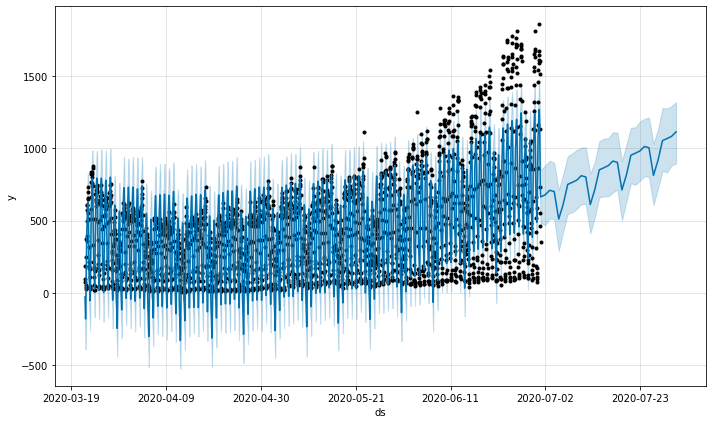

In [70]:
# Plot the fit to past data and future forecast.
fig1 = model.plot(forecast)
 

plt.show()

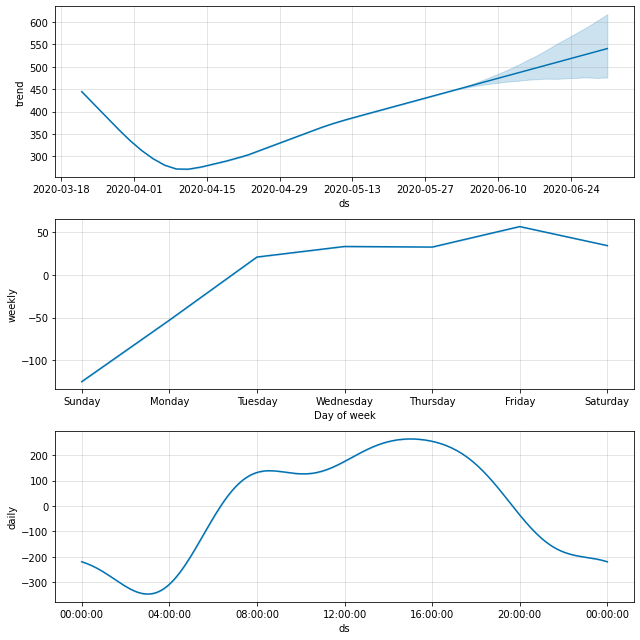

In [64]:
# Plot breakdown of components.
fig2 = model.plot_components(forecast) 

In [65]:
se = np.square(forecast.loc[:, 'yhat'] - fb_df['y'])
mse = np.mean(se)
rmse = np.sqrt(mse)
print('MSE:', mse, 'rmse:', rmse)
placeholder_man['fbprophet'] = rmse
placeholder_man

MSE: 7132.762761655327 rmse: 84.45568519439841


{'naive_forecast_baseline': 649.1469776646204,
 'moving_average_baseline': 264.77391785368604,
 'rmse_holt_linear': 101.45008150531622,
 'rmse_holt_winter': 45.0425549718788,
 'arima_1': 66.24174011651407,
 'arima_2': 108.2976291469606,
 'sarima_1': 43.36324070854471,
 'sarimax_1': 43.01682788966126,
 'fbprophet': 84.45568519439841}

Even though RMSE score for fbprophet was not as high, fbprophet was able to catch the seasonality and trend within the dataset and forecast from it. As Phase 3 and 4 enter in July, we would expect to see the incline.  If I add exogenous variables in the model, there is a chance fbprophet do even better. 